# Fine Tuning For BERT Models with TPU

In [1]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [2]:
strategy = tf.distribute.TPUStrategy(resolver)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Library

In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv('/content/drive/MyDrive/hepsiburada.csv', encoding="utf-8")

In [6]:
df.head()

,Rating,Review
0,1,3 yıldır tık demedi. :)
1,1,3 yıldır kullanıyorum müthiş
2,1,Ürün bugün elime geçti çok fazla inceleme fırs...
3,1,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,1,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [7]:
df.Rating.value_counts()

1    229821
0     13676
Name: Rating, dtype: int64

In [8]:
df.Rating.value_counts(normalize=True)

1    0.943835
0    0.056165
Name: Rating, dtype: float64

In [9]:
df.Rating = df.Rating.map({1:0, 0:1})

In [10]:
X = df['Review'].values
y = df['Rating'].values

## Train Test Split

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

### Tokenization Example For BERT

https://huggingface.co/dbmdz/bert-base-turkish-uncased

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [13]:
text = "Şentepeli Şükrü abi çok güzel bir insan?😊"
 
tokenizer.tokenize(text)

['sent',
 '##epe',
 '##li',
 'suk',
 '##ru',
 'abi',
 'cok',
 'guzel',
 'bir',
 'insan',
 '?',
 '😊']

In [14]:
sentence = "Şentepeli Şükrü abi çok güzel bir insan?😊"
tokens = tokenizer.encode(sentence, add_special_tokens=True)
print(tokens)
print(len(tokens))

[2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3]
14


### Fixing token counts of all documents

In [15]:
# For every sentence...
max_token = []
for sent in X:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_token.append(len(input_ids))

print('Max sentence length: ', max(max_token))

Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  546


In [16]:
list = [5, 10, 8, 9, 12, 15, 4]
print(np.array(list) <= 10)
print(sum(np.array(list) <= 10)/len(list))

[ True  True  True  True False False  True]
0.7142857142857143


In [17]:
np.array(max_token).mean()

39.53032686234327

In [18]:
sum(np.array(max_token) < 160) / len(max_token)

0.9849115184170647

### Transformation Vectors to Matrices

In [19]:
sentence = "Şentepeli Şükrü abi çok güzel bir insan?😊"
tokens = tokenizer.encode_plus(sentence, add_special_tokens=True)
print(tokens)

{'input_ids': [2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [20]:
tokens = tokenizer.encode_plus(sentence, max_length=160, truncation=True,
                              padding='max_length', add_special_tokens=True)
tokens

{'input_ids': [2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [21]:
seq_len = 160
num_samples = len(X)

Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

In [30]:
Xids[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [22]:
Xmask[:2]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [23]:
print(tokens['input_ids'])
print(tokens['attention_mask'])

[2, 15955, 11679, 2033, 28792, 2239, 8621, 6191, 14533, 1993, 2419, 35, 989, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [24]:
Xids[0] = tokens['input_ids']
Xmask[0] = tokens['attention_mask']

In [25]:
Xids[0]

array([2.0000e+00, 1.5955e+04, 1.1679e+04, 2.0330e+03, 2.8792e+04,
       2.2390e+03, 8.6210e+03, 6.1910e+03, 1.4533e+04, 1.9930e+03,
       2.4190e+03, 3.5000e+01, 9.8900e+02, 3.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e

In [26]:
Xmask[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [27]:
def transformation(X):
  # set array dimensions
  seq_len = 160
  num_samples = len(X)

  # initialize empty zero arrays
  Xids = np.zeros((num_samples, seq_len))
  Xmask = np.zeros((num_samples, seq_len))

    
  for i, phrase in enumerate(X):
      tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                      padding='max_length', add_special_tokens=True) 
      
      # assign tokenized outputs to respective rows in numpy arrays
      Xids[i] = tokens['input_ids']
      Xmask[i] = tokens['attention_mask']
  return Xids, Xmask

In [28]:
Xids_train, Xmask_train = transformation(X_train)

Xids_test, Xmask_test = transformation(X_test)

In [29]:
print("Xids_train.shape  :", Xids_train.shape)
print("Xmask_train.shape :", Xmask_train.shape)
print("Xids_test.shape   :", Xids_test.shape)
print("Xmask_test.shape  :", Xmask_test.shape)

Xids_train.shape  : (219147, 160)
Xmask_train.shape : (219147, 160)
Xids_test.shape   : (24350, 160)
Xmask_test.shape  : (24350, 160)


In [30]:
y_train

array([0, 0, 0, ..., 0, 1, 0])

In [31]:
labels_train = y_train.reshape(-1,1)
labels_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [0]])

In [32]:
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
labels_test = y_test.reshape(-1,1)
labels_test

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [34]:
from tensorflow.keras.utils import to_categorical

l = np.array([0, 1, 3, 5, 4, 2])
to_categorical(l, 6) 

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

## Transformation Matrix to Tensor

In [35]:
import tensorflow as tf

dataset_train = tf.data.Dataset.from_tensor_slices((Xids_train, Xmask_train, labels_train))
dataset_train

<TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [36]:
dataset_test = tf.data.Dataset.from_tensor_slices((Xids_test, Xmask_test, labels_test))
dataset_test

<TensorSliceDataset element_spec=(TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(160,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [37]:
def map_func(Xids, Xmask, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask}, labels

In [38]:
# then we use the dataset map method to apply this transformation
dataset_train = dataset_train.map(map_func)
dataset_test = dataset_test.map(map_func)

In [39]:
dataset_train

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.float64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [40]:
dataset_test

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(160,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(160,), dtype=tf.float64, name=None)}, TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

## Batch Size and Shuffle Train Dataset

In [41]:
batch_size = 32 # 16, 32

# batch_size 
# fit into a batch of 32
train_ds = dataset_train.batch(batch_size) # Gözlemlerin yeri sabit olduğundan metricler için kullanacağız. 
val_ds = dataset_test.batch(batch_size)

length = len(X_train)
train_ds2 = dataset_train.shuffle(buffer_size = length, reshuffle_each_iteration=True).batch(batch_size) 
# Buffer size boyutu train datasının boyutuyla aynı olduğunda eğitim aşamasında train datası en iyi şekilde karıştırılır.

## Creating Model

In [42]:
def create_model():
    from transformers import TFAutoModel
    model = TFAutoModel.from_pretrained("dbmdz/bert-base-turkish-uncased")
    input_ids = tf.keras.layers.Input(shape=(160,), name='input_ids', dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(160,), name='attention_mask', dtype='int32')

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]

    x = tf.keras.layers.Dense(160, activation='relu')(embeddings)
    x = tf.keras.layers.Dropout(0.1, name="dropout")(x) #0.1
    y = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(x)

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

In [43]:
with strategy.scope():
  
  optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5) #3e-5, 5e-5
  loss = tf.keras.losses.BinaryCrossentropy()
  recall = tf.keras.metrics.Recall()
  model3 = create_model()
  model3.compile(optimizer=optimizer, loss=loss, metrics=[recall])

Some layers from the model checkpoint at dbmdz/bert-base-turkish-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-turkish-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [44]:
#pd.Series(y).value_counts(normalize=True)

In [45]:
#weights = {0:0.05, 1:0.95}

In [46]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 160)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 160)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 160,                                           

In [47]:
history = model3.fit(
    train_ds2, validation_data= val_ds, class_weight= {0:1, 1:4},
    epochs=1) #epoch= 2 or 3

6849/6849 [==============================] - 808s 105ms/step - loss: 0.1779 - recall: 0.8232 - val_loss: 0.0794 - val_recall: 0.8611


## Model evaluation

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model3.predict(val_ds) >= 0.5


print(classification_report(y_test, y_pred))

761/761 [==============================] - 35s 38ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     22982
           1       0.71      0.86      0.78      1368

    accuracy                           0.97     24350
   macro avg       0.85      0.92      0.88     24350
weighted avg       0.98      0.97      0.97     24350



In [49]:
y_train_pred = model3.predict(train_ds) >= 0.5


print(classification_report(y_train, y_train_pred)) 

6849/6849 [==============================] - 205s 30ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    206839
           1       0.76      0.91      0.83     12308

    accuracy                           0.98    219147
   macro avg       0.88      0.95      0.91    219147
weighted avg       0.98      0.98      0.98    219147



In [50]:
y_train_pred2 = model3.predict(train_ds2) >= 0.5


print(classification_report(y_train, y_train_pred2)) 

6849/6849 [==============================] - 195s 28ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.94    206839
           1       0.06      0.07      0.06     12308

    accuracy                           0.88    219147
   macro avg       0.50      0.50      0.50    219147
weighted avg       0.89      0.88      0.89    219147



Unweighted model

TEST SET
                
                precision    recall  f1-score   support

           0       0.99      0.97      0.98     22987
           1       0.79      0.80      0.80      1365

  

TRAIN SET

                precision    recall  f1-score   support

           0       1.00      0.97      0.99    206825
           1       0.85      0.85      0.85     12311

    


761/761 [==============================] - 24s 28ms/step


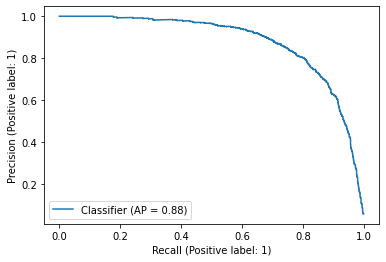

In [53]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

y_pred_proba = model3.predict(val_ds)

PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba)
plt.show();

In [86]:
model3.save("/content/drive/MyDrive/sentiment_model.h5")

In [87]:
from tensorflow.keras.models import load_model


model4 = load_model('/content/drive/MyDrive/sentiment_model.h5')

In [88]:
# initialize tokenizer from transformers
from transformers import AutoTokenizer, TFAutoModel

tokenizers = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-uncased")

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizers.encode_plus(text, max_length=160,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True,
                                   return_tensors='tf')
  
    return {'input_ids': tokens['input_ids'],      
            'attention_mask': tokens['attention_mask']} 

In [109]:
review1 = "çok beğendim herkese tavsiye ederim"
review2 = "süper ürün aynı gün elime geçti"
review3 = "büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım"
review4 = "kelimelerle tarif edilemez"
review5 = "tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten"
review6 = "hiç resimde gösterildiği gibi değil"
review7 = "kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler"
review8 = "hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum"
review9 = "tam bir fiyat performans ürünü"
review10 = "beklediğim gibi çıkmadı"
review11 = "on numara beş yıldız"
review12 = "bu kargoyu biran önce bırakın. yoksa üründe sıkıntı yok"
review13 = "televizyonun görüntü kalitesi çok kötü, dün akşam evde arkadaşlarla toplandık. yedik, içtik, sohbet ettik. Sonra televizyonda Türkiye - İngiltere maçını seyrettik. "
review14 = '1 gün gibi kısa bir sürede elime geçti. Ve bu fıyata süper bir ürün tavsiye ederim. Lakin eli büyük olan kişiler daha büyük modelini tercih edebilirler ortaboy ürün. Teşekkürler '
review15 = "alınca anlarsın anyayı konyayı"
review16 = "çöpe atacak paran varsa al"
review17= "Telefon çok da kötü değil"
review18 = "al da gününü gör"
review19 = "Ürün harika ama satıcı ve kargo berbat"
review20 = "kargo süper ama ürün berbat"
review21 = "Aldigim TV cok kaliteli diye dusunmustum, sonradan cok da iyi bir TV olmadigini dusundum, ama neyse yine de memnunum."
review22 = "😊"
review23 = ":)"
review24 = "I ❤️ you"
review25 = 'telefon kesinlikle bu parayı hak etmiyor. yeni hiç bir özelliği yok. ancak küçük ekran sevenler için iyi bir telefon'
review26 = 'müthiş bir telefon ama bu parayı hak etmiyor'
reviews = [review1, review2, review3, review4, review5, review6, review7, review8, review9, review10, review11, review12, review13, review14, review15, review16, review17, 
           review18, review19, review20, review21, review22, review23, review24, review25, review26] 

In [110]:
probs = []
for i in reviews:

  in_tensor = prep_data(i)

  prob = model4.predict(in_tensor)[0][0]

  probs.append(prob)

1/1 [==============================] - 0s 192ms/step


In [111]:
in_tensor

{'input_ids': <tf.Tensor: shape=(1, 160), dtype=int32, numpy=
 array([[   2, 2783, 5830, 1993, 3084, 2201, 2011, 8663, 2303, 9567,    3,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,

In [112]:
model4.predict(in_tensor)

1/1 [==============================] - 0s 192ms/step


array([[0.71006334]], dtype=float32)

In [113]:
model4.predict(in_tensor)[0][0]

1/1 [==============================] - 0s 188ms/step


0.71006334

In [114]:
probs

[0.0013206474,
 0.0020754011,
 0.9985483,
 0.013375679,
 0.98778343,
 0.99673295,
 0.009441297,
 0.9988051,
 0.001162276,
 0.9985416,
 0.0016913788,
 0.03950867,
 0.9977518,
 0.0034353388,
 0.064463675,
 0.7699374,
 0.11045295,
 0.02207765,
 0.37644976,
 0.9952983,
 0.18084016,
 0.009348301,
 0.012465779,
 0.016036171,
 0.9640639,
 0.71006334]

In [115]:
classes  = (np.array(probs) >= 0.5).astype("int")
classes

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1])

In [116]:
my_dict = {"Review":reviews, "prob":probs, "classes":classes}

In [117]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

,Review,prob,classes
0,çok beğendim herkese tavsiye ederim,0.001321,0
1,süper ürün aynı gün elime geçti,0.002075,0
2,büyük bir hayal kırıklığı yaşadım bu ürünü bu markaya yakıştıramadım,0.998548,1
3,kelimelerle tarif edilemez,0.013376,0
4,tasarımı harika ancak kargo çok geç geldi ve ürün açılmıştı hayal kırıklığı gerçekten,0.987783,1
5,hiç resimde gösterildiği gibi değil,0.996733,1
6,kötü yorumlar gözümü korkutmuştu ancak hiçbir sorun yaşamadım teşekkürler,0.009441,0
7,hiç bu kadar kötü bir satıcıya denk gelmemiştim ürün siparişimi iptal ediyorum,0.998805,1
8,tam bir fiyat performans ürünü,0.001162,0
9,beklediğim gibi çıkmadı,0.998542,1


In [118]:
count=0
for i in X_train:
  if "gününü gör" in i.lower():
    count+=1
print(count)

0


In [119]:
count=0
for i in X_train:
  if "anyayı konyayı" in i.lower():
    count+=1
print(count)

0


In [120]:
count=0
for i, j in enumerate(X):
  if "çöpe atacak paran" in j.lower() and y[i]==1:
    count+=1
    print(i)
print(count)

158068
218693
2


In [121]:
X[158068]

'beş para etmez çöpe atacak paranız varsa alın'